# Part 4: Model analysis

Besides accelerating simulations, Archimedes also makes it easy to do more advanced analyses like identifying trim conditions and performing stability analysis.

First let's recreate the same model we used for Part 3:


In [ ]:
# ruff: noqa: N802, N803, N806, N815, N816
import os

import matplotlib.pyplot as plt
import multirotor
import numpy as np
from scipy.optimize import root

import archimedes as arc

THEME = os.environ.get("ARCHIMEDES_THEME", "dark")
arc.theme.set_theme(THEME)

np.set_printoptions(precision=3, suppress=True)

In [2]:
m = 2.0  # Body mass [kg]
R = 0.15  # Rotor radius (also boom length) [m]
H = 0.15  # Body height [m]
L = 0.30  # Rotor arm length [m]
rho = 1.225  # Density of air [kg/m^3]
Cd = 1.6  # Drag coefficient [-]
kF = 1e-5  # Force coefficient for rotors [kg-m]
kM = 1e-7  # Moment coefficient for rotors [kg-m^2]
g0 = 9.81  # Gravitational acceleration [m/s^2]

# Inertia matrix of a cylinder with mass m, radius R, and height h
J_B = np.array(
    [
        [m / 12 * (3 * R**2 + H**2), 0, 0],
        [0, m / 12 * (3 * R**2 + H**2), 0],
        [0, 0, m / 2 * R**2],
    ]
)

# Four rotors mounted at 45, 135, 225, and 315 degrees
# No canting and alternating spin directions
rotors = []
theta = np.pi / 4
ccw = True
for i in range(4):
    rotors.append(
        multirotor.RotorGeometry(
            offset=np.array([L * np.cos(theta), L * np.sin(theta), 0]),
            ccw=ccw,
        )
    )
    theta += np.pi / 2
    ccw = not ccw

# Construct the model components for gravity, vehicle drag, and
# rotor aerodynamics
gravity_model = multirotor.ConstantGravity(g0=g0)
drag_model = multirotor.QuadraticDragModel(
    rho=rho,
    Cd=Cd,
    A=R * H,
)
rotor_model = multirotor.QuadraticRotorModel(kF=kF, kM=kM)

# Create the complete vehicle model
vehicle = multirotor.MultiRotorVehicle(
    m=m,
    J_B=J_B,
    rotors=rotors,
    drag_model=drag_model,
    rotor_model=rotor_model,
    gravity_model=gravity_model,
    attitude="euler",
)


## Finding trim conditions for forward flight

For instance, a common task for flight vehicle analysis is identifying steady trim conditions.
For a quadrotor model like ours, we can set up a trim problem by defining a target translational velocity $\mathbf{v}_N$ (in the inertial frame) and angular velocity $\mathbf{\omega}_B$.
Nothing in our model depends on position, so we can arbitrarily set that to zero.
If we assume zero yaw angle, this leaves us six degrees of freedom: roll angle, pitch angle, and four rotor angular velocities.
The body-frame velocity is then derived from the inertial-frame velocity via the Euler-angle rotations matrix:

$$
\mathbf{v}_B =  ~^B\!\mathbf{C}^N \mathbf{v}_N
$$

For a steady operating point we want to require that the six acceleration quantities $\dot{\mathbf{v}}_B$ and $\dot{\mathbf{\omega}}_B$ in the state derivative vector are zero.
Putting it all together, we can define a residual function as follows:

In [ ]:
# Target forward velocity in the inertial frame
v_N = np.array([10.0, 0.0, 0.0])

p_N = np.zeros(3)
w_B = np.zeros(3)


def residual(p):
    phi, theta = p[:2]  # (roll, pitch) angles
    u = p[2:]  # Rotor angular velocities
    rpy = np.array([phi, theta, 0.0], like=p)
    C_BN = multirotor.dcm(rpy)
    v_B = C_BN @ v_N  # Rotate velocity to the body frame
    x = vehicle.State(p_N, rpy, v_B, w_B)
    x_t = vehicle.dynamics(0.0, x, u)
    return np.hstack([x_t.v_B, x_t.w_B])  # Residuals of dynamics equations only


u0 = 2.0  # Initial guess for rotor angular velocity
# Initial guess for the parameter vector
p0 = np.array([0.0, 0.0, u0, u0, u0, u0])

residual(p0)

array([-1.103,  0.   ,  9.81 ,  0.   , -0.   ,  0.   ])


This gives us a nonlinear algebraic system with six equations in six unknowns, which can be efficiently solved using a Newton-Raphson method.
In Archimedes, this is accessible with the `root` function, which has a similar interface to `scipy.optimize.root` except that it uses (sparse) automatic differentiation to efficiently evaluate the Jacobian matrices.

In [ ]:
p_trim = arc.root(residual, p0)

phi_trim = p_trim[0]
theta_trim = p_trim[1]
u_trim = p_trim[2:]

rpy_trim = np.array([phi_trim, theta_trim, 0.0])
C_BN = multirotor.dcm(rpy_trim)
v_B_trim = C_BN @ v_N

x_trim = vehicle.State(p_N, rpy_trim, v_B_trim, w_B)

print(f"roll: {np.rad2deg(phi_trim):.2f} deg")
print(f"pitch: {np.rad2deg(theta_trim):.2f} deg")
print(f"v_B: {v_B_trim}")
print(f"u: {u_trim}")

roll: 0.00 deg
pitch: -6.41 deg
v_B: [ 9.937  0.    -1.117]
u: [702.558 702.558 702.558 702.558]


Alternatively, the SciPy root-finding solver can still be employed directly, with the autodiff Jacobian constructed using the `arc.jac` function transformation, giving access to alternative algorithms like those in MINPACK:

In [7]:
sol = root(residual, p0, jac=arc.jac(residual), method="lm")

print(f"Roll: {np.rad2deg(sol.x[0]):.2f} deg")
print(f"Pitch: {np.rad2deg(sol.x[1]):.2f} deg")
print(f"u: {sol.x[2:]}")

Roll: 0.00 deg
Pitch: -6.41 deg
u: [702.558 702.558 702.558 702.558]


## Linear stability analysis

In flight dynamics it is common to decouple the "longitudinal" from the "lateral-directional" degrees of freedom.
Broadly speaking, the longitudinal degrees of freedom relate to the body-frame $x-z$ plane:

* Pitch: $\theta$
* Surge: $v_B^x$
* Heave: $v_B^z$
* Pitch rate: $q$

The other states are assumed to be in their trim values.
We can analyze the stability of the longitudinal system by defining a function that maps from these degrees of freedom to their time derivatives, and then using `arc.jac` to compute the Jacobian matrices about the trim point.

In [8]:
def longitudinal_dofs(x):
    return np.hstack(
        [
            x.att[1],  # theta
            x.v_B[0],  # vx
            x.v_B[2],  # vz
            x.w_B[1],  # q
        ]
    )


x_lon_trim = longitudinal_dofs(x_trim)


# Right-hand side function for the longitudinal dynamics
def f_lon(x_lon, u):
    theta, vx, vz, q = x_lon  # Longitudinal degrees of freedom
    x = vehicle.State(
        np.zeros(3),
        np.hstack([phi_trim, theta, 0.0]),
        np.hstack([vx, v_B_trim[1], vz]),
        np.hstack([0.0, q, 0.0]),
    )
    x_t = vehicle.dynamics(0.0, x, u)
    return longitudinal_dofs(x_t)


# Linearized state-space matrices
A_lon = arc.jac(f_lon, 0)(x_lon_trim, u_trim)
B_lon = arc.jac(f_lon, 1)(x_lon_trim, u_trim)

print(f"A_lon:\n{A_lon}")
print(f"\nB_lon:\n{B_lon}")

A_lon:
[[ 0.     0.     0.     1.   ]
 [-9.749 -0.219  0.012  1.117]
 [ 1.096  0.012 -0.112  9.937]
 [ 0.     0.     0.     0.   ]]

B_lon:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [-0.007 -0.007 -0.007 -0.007]
 [ 0.199 -0.199 -0.199  0.199]]


This gives us a linearized state-space system in the form

$$
\dot{\mathbf{x}}_\mathrm{lon} = A_\mathrm{lon} \mathbf{x}_\mathrm{lon} + B_\mathrm{lon} u
$$

We can use this to analyze stability and system behavior in various ways.  For instance, assuming uniform changes to the rotor velocity, we can contruct a transfer function from input to heave velocity by defining the uniform $m \times 1$ control matrix

$$
\hat{B}_\mathrm{lon} = B_\mathrm{lon} \begin{bmatrix} 1 \\ 1 \\ 1 \\ 1 \end{bmatrix}
$$

and the output matrix

$$
\hat{C}_\mathrm{lon} = \begin{bmatrix} 0 & 0 & 1 & 0 \end{bmatrix},
$$

leading to the transfer function

$$
H(s) = \hat{C}_\mathrm{lon} \left(A_\mathrm{lon} - s I \right) \hat{B}_\mathrm{lon}.
$$

Alternatively, this can be analyzed easily by using the [Python Control Systems Library](https://python-control.readthedocs.io/):

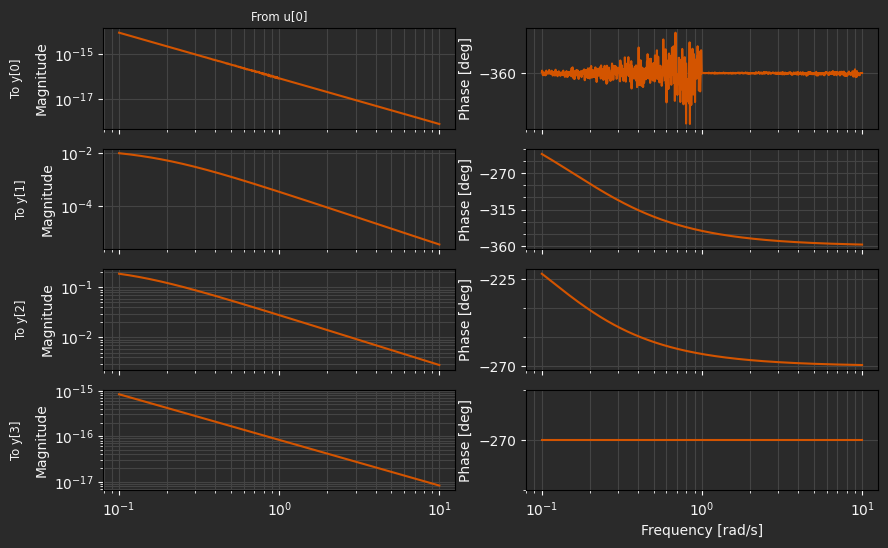

In [9]:
import control

C_hat = np.eye(4)
B_hat = B_lon @ np.ones((4, 1))
D_lon = np.zeros((C_hat.shape[0], 1))

lti_sys = control.StateSpace(A_lon, B_hat, C_hat, D_lon)
fig, ax = plt.subplots(4, 2, figsize=(10, 6), sharex=True)
control.bode_plot(lti_sys, ax=ax)
plt.show()

The lateral-directional dynamics include the remaining dynamical degrees of freedom relevant for perturbations to the trim condition:

* Roll: $\phi$
* Side-slip velocity: $v_B^y$
* Roll rate: $q$
* Yaw rate: $r$

In [10]:
def lateral_dofs(x):
    return np.hstack(
        [
            x.att[0],  # phi
            x.v_B[1],  # vy
            x.w_B[0],  # p
            x.w_B[2],  # r
        ]
    )


x_lat_trim = lateral_dofs(x_trim)


# Right-hand side function for the lateral-directional dynamics
def f_lat(x_lat, u):
    phi, vy, p, r = x_lat  # Perturbations
    x = vehicle.State(
        np.zeros(3),
        np.hstack([phi, theta_trim, 0.0]),
        np.hstack([v_B_trim[0], vy, v_B_trim[2]]),
        np.hstack([p, 0.0, r]),
    )
    x_t = vehicle.dynamics(0.0, x, u)
    return lateral_dofs(x_t)


# Linearized state-space matrices
A_lat = arc.jac(f_lat, 0)(x_lat_trim, u_trim)
B_lat = arc.jac(f_lat, 1)(x_lat_trim, u_trim)

print(f"A_lat:\n{A_lat}")
print(f"\nB_lat:\n{B_lat}")

A_lat:
[[ 0.     0.     1.    -0.112]
 [ 9.749 -0.11  -1.117 -9.937]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]]

B_lat:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [-0.199 -0.199  0.199  0.199]
 [ 0.006 -0.006  0.006 -0.006]]
